# Introduction
This kernel has been created by the [Information Systems Lab](http://islab.uom.gr) to introduce students of the [University of Macedonia](http://www.uom.gr/index.php?tmima=2&categorymenu=2), Greece to Machine Learning & Data Science.

## The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.

## Objective
The objective of this Kernel is to introduce students to predictive business analytics with Python through the Instacart case. 

By the time you finish this example, you will be able to:
* Describe the steps of creating a predictive analytics model
* Use Python and Pandas package to manipulate data
* Use Python and Pandas package to create, combine, and delete DataFrames
* Use Random Forests to create a predictive model
* Apply the predictive model in order to make a prediction
* Create a submission file for the competition of Instacart

## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user). 

<img src="https://i.imgur.com/S0Miw3m.png" width="350">

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below). 

<img src="https://i.imgur.com/SxK2gsR.png" width="350">

As a result we need to come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<img src="https://i.imgur.com/Yb1CKAF.png" width="600">

## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Create submission file</b>: In this final step we create the submission file with our predictions for Instacart's competition.
7. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import and Reshape Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

## 1.1 Import the required packages
The garbage collector (package gc), attempts to reclaim garbage, or memory occupied by objects (e.g., DataFrames) that are no longer in use by Python ([ref1](https://www.techopedia.com/definition/1083/garbage-collection-gc-general-programming), [ref2](https://en.wikipedia.org/wiki/Garbage_collection_(computer_science)). This package will eliminate our risk to exceed the 16GB threshold of available RAM that Kaggle offers.

The **"as"** reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
matplotlib.use('Agg')
#matplotlib.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python. Towards this end, we use the .read_csv() function, which is included in the Pandas package. Reading in data with the .read_csv( ) function returns a DataFrame.

In [2]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [3]:
orders = pd.read_csv('input/orders.csv' )
order_products_train = pd.read_csv('input/order_products__train.csv')
order_products_prior = pd.read_csv('input/order_products__prior.csv')
products = pd.read_csv('input/products.csv')
aisles = pd.read_csv('input/aisles.csv')
departments = pd.read_csv('input/departments.csv')

This step results in the following DataFrames:
* <b>orders</b>: This table includes all orders, namely prior, train, and test. It has single primary key (<b>order_id</b>).
* <b>order_products_train</b>: This table includes training orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>order_products_prior </b>: This table includes prior orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>products</b>: This table includes all products. It has a single primary key (<b>product_id</b>)
* <b>aisles</b>: This table includes all aisles. It has a single primary key (<b>aisle_id</b>)
* <b>departments</b>: This table includes all departments. It has a single primary key (<b>department_id</b>)

If you want to reduce the execution time of this Kernel you can use the following piece of code by uncomment it. This will trim the orders DataFrame and will keep a 10% random sample of the users. You can use this for experimentation.

We now use the .head( ) method in order to visualise the first 10 rows of these tables. Click the Output button below to see the tables.

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## 1.3 Reshape data
We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [10]:
# We convert character variables into category. 
# In Python, a categorical variable is called category and has a fixed number of different values
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

## 1.4 Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
We create a new DataFrame, named <b>op</b> which combines (merges) the DataFrames <b>orders</b> and <b>order_products_prior</b>. Bear in mind that <b>order_products_prior</b> DataFrame includes only prior orders, so the new DataFrame <b>op</b>  will contain only these observations as well. Towards this end, we use pandas' merge function with how='inner' argument, which returns records that have matching values in both DataFrames. 
<img src="https://i.imgur.com/zEK7FpY.jpg" width="400">

In [11]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


The table contains for all the customers **(user_id)**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the orders **(order_id)** that they have placed accompanied with: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the products **(product_id)** that have been bought in each order

# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer
- 2.1.2 How frequent a customer has reordered products

### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a **user** DataFrame to store the results.

In [12]:
## First approach in one step:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()

## Second approach in two steps: 
#1. Save the result as DataFrame with Double brackets --> [[ ]] 
#user = op.groupby('user_id')[['order_number']].max()
#2. Rename the label of the column
#user.columns = ['u_total_orders']
#user.head()

,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [13]:
# Reset the index of the DF so to bring user_id from index to column (pre-requisite for step 2.4)
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


### 2.1.2 How frequent a customer has reordered products

This feature is a ratio which shows for each user in what extent has products that have been reordered in the past: <br>
So we create the following ratio: <br>

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id)=&space;\frac{total\&space;times\&space;of\&space;reorders}{total\&space;number\&space;of\&space;purchased\&space;products\&space;from\&space;all\&space;baskets}" title="probability\ reordered\ (user\_id)= \frac{total\ times\ of\ reorders}{total\ number\ of\ purchased\ products\ from\ all\ baskets}" />

The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).

E.g., for a user that has ordered 6 products in total, where 3 times were reorders, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1}{6}&space;=&space;0,5) 

To create the above ratio we .groupby() order_products_prior by each user and then calculate the mean of reordered.


In [14]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the user DataFrame

<img src="https://i.imgur.com/wMmC4hb.jpg" width="400">

In [15]:
user = user.merge(u_reorder, on='user_id', how='left')
user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product
- 2.2.2 What is the probability for a product to be reordered

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers). We create a **prd** DataFrame to store the results.

In [16]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd.head()

,p_total_purchases
product_id,
1,1852
2,90
3,277
4,329
5,15


In [17]:
# Reset the index of the DF so to bring product_id rom index to column (pre-requisite for step 2.4)
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


## 2.2.2 What is the probability for a product to be reordered
In this section we want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability as below:
<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;probability\&space;reordered\&space;(product\_id)=&space;\frac{number\&space;of\&space;reorders}{total\&space;number\&space;of\&space;orders\&space;}" title="probability\ reordered\ (product\_id)= \frac{number\ of\ reorders}{total\ number\ of\ orders\ }" />

Example: The product with product_id=2 is included in 90 purchases but only 12 are reorders. So we have:  

<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;p\_reorder\(product\_id\mathop{==}&space;2&space;)=&space;\frac{12}{90}=&space;0,133" title="\large p\_reorder\(product\_id\mathop{==} 2 )= \frac{12}{90}= 0,133" />

### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
Before we proceed to this estimation, we remove all these products that have less than 40 purchases in order the calculation of the aforementioned ratio to be meaningful.

Using .groupby() we create groups for each product and using .filter( ) we keep only groups with more than 40 rows. Towards this end, we indicate a lambda function.

### 2.2.2.2 Group products, calculate the mean of reorders

To calculate the reorder probability we will use the aggregation function mean() to the reordered column. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

The .mean() calculates how many times a product has been reordered, divided by how many times has been ordered in total. 

E.g., for a product that has been ordered 9 times in total, where 4 times has been reordered, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1&plus;0&plus;0&plus;1}{9}&space;=&space;0,44) 

We calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.

In [ ]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head(10)

In [19]:

p_reorder = op.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio').reset_index()
p_reorder.head(10)

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000
5,6,0.375000
6,7,0.400000
7,8,0.503030
8,9,0.525641
9,10,0.506998


### 2.2.2.3 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the prd DataFrame
<img src="https://i.imgur.com/dOVWPKb.jpg" width="400">

In [20]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


#### 2.2.2.4 Fill NaN values
As you may notice, there are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the p_reorder DataFrame. **As we performed a left join with prd DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.**

For these products we their NaN value with zero (0):

In [21]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


> Our final DataFrame should not have any NaN values, otherwise the fitting process (chapter 4) will throw an error!

## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product
- 2.3.2 How frequently a customer bought a product after its first purchase
- 2.3.3 How many times a customer bought a product on its last 5 orders

### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product. We save the results on new **uxp** DataFrame.

In [22]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [23]:
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


### 2.3.2 How frequently a customer bought a product after its first purchase
This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product):

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought\_N}{Order\_Range\_D}" title="\large probability\ reordered\ (user\_id\ , product\_id) = \frac{Times\_Bought\_N}{Order\_Range\_D}" />

* Times_Bought_N = Times a user bought a product
* Order_Range_D = Total orders placed since the first user's order of a product

To clarify this, we examine the use with user_id:1 and the product with product_id:13032. User 1 has made 10 orders in total.She has bought the product 13032 **for first time in her 2nd order** and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range_D variable is created using two supportive variables:
* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

In the next blocks we show how we create:
1. The numerator 'Times_Bought_N'
2. The denumerator 'Order_Range_D' with the use of the supportive variables 'total_orders' & 'first_order_number' 
3. Our final ratio 'uxp_order_ratio'

### 2.3.2.1 Calculate the numerator ('Times_Bought_N')

To answer this question we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [24]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

### 2.3.2.2 Calculate the denumerator ('Order_Range_D')
To calculate the denumerator, we first calculate the total orders of each user & first order number for each user and every product purchase.

In order to calculate the total number of orders of each cutomer ('total_orders') we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [25]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In order to calculate the order number where the user bought a product for first time ('first_order_number') we .groupby( ) by both user_id & product_id and we select the order_number column and we retrieve the .min( ) value.

In [26]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join:
<img src="https://i.imgur.com/bhln0tn.jpg" width="250">

In [28]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


The denominator ('Order_Range_D') now can be created with simple operations between the columns of span DataFrame:

In [29]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()
# Remove the two unneeded columns
span = span.drop(columns=['total_orders', 'first_order_number'])
span.head()

,user_id,product_id,Order_Range_D
0,1,196,10
1,1,10258,9
2,1,10326,6
3,1,12427,10
4,1,13032,9


### 2.3.2.3 Create the final ratio "uxp_reorder_ratio"

We merge **times** DataFrame, which contains the numerator, and **span** DataFrame, which contains the denumerator of our desired ratio. **As both variables derived from the combination of users & products, any type of join will keep all the combinations.**

<img src="https://i.imgur.com/h7m1bFh.jpg" width="250">

In [30]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,Order_Range_D
0,1,196,10,10
1,1,10258,9,9
2,1,10326,1,6
3,1,12427,10,10
4,1,13032,3,9



We divide the Times_Bought_N by the Order_Range_D for each user and product.

In [31]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head() 

,user_id,product_id,Times_Bought_N,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1.000000
1,1,10258,9,9,1.000000
2,1,10326,1,6,0.166667
3,1,12427,10,10,1.000000
4,1,13032,3,9,0.333333



We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'


In [32]:
uxp_ratio = uxp_ratio.drop(columns=['Times_Bought_N', 'Order_Range_D'])
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [33]:
#Remove temporary DataFrames
del [times, first_order_no, span]

### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

<img src="https://i.imgur.com/hPJXBuB.jpg" width="250">

In [34]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


### 2.3.3 How many times a customer bought a product on its last 5 orders
For this feature, we want to keep the last five orders for each customer and get how many times bought any product on them. To achieve this we need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio:

![](https://latex.codecogs.com/gif.latex?times%5C%20last%20%5C5%5C%20%28of%5C%20a%5C%20purchased%5C%20product%5C%20from%5C%20a%5C%20user%29%3D%5Cfrac%7BTimes%5C%20a%5C%20user%5C%20bought%5C%20a%5C%20product%5C%20on%5C%20its%5C%20last%5C%205%5C%20orders%7D%7BTotal%5C%20orders%5C%20%3D5%7D)

#### 2.3.3.1 Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
In this step we show how we create a reverse order_number for each customer. <br>
Have a look at the orders of customer 1 (user_id == 1)

In [35]:
op[op.user_id==1].head(45)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


Our goal is a to create a new column ('order_number_back') which indicates the last order as first, the second from the end as second and so on. To achieve this, we get the highest order_number (max) for user_id==1 and we subtract the order_number of each order from it. Thus for last order (order_number == 10) that will be: 
<br>
<br>

![order_number_back](https://latex.codecogs.com/png.latex?%5Cdpi%7B200%7D%20%5Ctiny%20%5Cfontsize%7B%20%7D%7Bbaselineskip%7D%20order%5C_number%5C_back%28x%29%3D%20order%5C_number.max%28%29%20-order%5C_number%28x%29%3D10%20-%2010%20%3D%200)

And as we want the last order to be marked as first, rather than zeroth, the previous formula will be:

![](https://latex.codecogs.com/png.latex?%5Cdpi%7B200%7D%20%5Ctiny%20%5Cfontsize%7B%20%7D%7Bbaselineskip%7D%20order%5C_number%5C_back%28x%29%3D%20order%5C_number.max%28%29%20-order%5C_number%28x%29%3D10%20-%2010%20&plus;1%3D%201)

> Note that order_number.max( ) is a single value, where order_number is a 1-D array (column/Series)

By applying the above formula to the orders of user_id == 1 we get the following results:
![](https://i.imgur.com/toda8ay.png)

In the next code block we perform the same calculations for all users. We .groupby( ) op by the user_id and we select the column order_number. With .transform(max) we request to get the highest number of the column order_number for each group & with minus (-) op.order_number we substract the order_number of each row. Finally we add 1 for the reason mentioned above.

> .transform( ) perform some group-specific computations and return a like-indexed object. 

In [36]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


Check that the formula has been applied to all users. Here we check the new column for a random user (user_id== 7):

In [37]:
op[op.user_id==7].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
411,2565571,7,prior,1,3,9,NaN,45628,1,0,20
412,2565571,7,prior,1,3,9,NaN,39275,2,0,20
413,2565571,7,prior,1,3,9,NaN,6361,3,0,20
414,2565571,7,prior,1,3,9,NaN,45066,4,0,20
415,2565571,7,prior,1,3,9,NaN,13249,5,0,20
416,2565571,7,prior,1,3,9,NaN,31683,6,0,20
417,2565571,7,prior,1,3,9,NaN,519,7,0,20
418,2565571,7,prior,1,3,9,NaN,37999,8,0,20
419,2565571,7,prior,1,3,9,NaN,49508,9,0,20
420,2565571,7,prior,1,3,9,NaN,29871,10,0,20


#### 2.3.3.2 Keep only the last five orders for each customer
With the use of order_number_back we can now select to keep only the last five orders of each customer:

In [38]:
op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4
34,550135,1,prior,7,1,9,20.0,10258,2,1,4
35,550135,1,prior,7,1,9,20.0,12427,3,1,4
36,550135,1,prior,7,1,9,20.0,25133,4,1,4
37,550135,1,prior,7,1,9,20.0,13032,5,1,4
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3


#### 2.3.3.3 Perform a .groupby( ) on users and products to get how many times each customer bought every product.
Having kept the last 5 orders for each user, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product.

In [39]:
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five.head(10)

times_last5
user_id product_id             
1       196                   5
        10258                 5
        12427                 5
        13032                 2
        25133                 5
        35951                 1
        38928                 1
        39657                 1
        46149                 3
        49235                 2

So for user_id==1, the product 196 has been ordered on all of its last five orders, where the product 35951 has been ordered only one time.

#### 2.3.3.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

<img src="https://i.imgur.com/ObfHDPl.jpg" width="400">

In [40]:
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')

del [op5 , last_five]
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,NaN
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


#### 2.3.3.6 Fill NaN values
If you check uxp DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not buy on its last five orders. For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [41]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,0.0
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called **data**) to have the following structure: 

<img style="float: left;" src="https://i.imgur.com/mI5BbFE.jpg" >






### 2.4.1 Merge uxp with user DataFrame
Here we select to perform a left join of uxp with user DataFrame based on matching key "user_id"

<img src="https://i.imgur.com/WlI84Ud.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the uxp (combination of user and products) DataFrame 
- all the **matching** observations of user DataFrame with uxp based on matching key **"user_id"**

The new DataFrame as we have already mentioned, will be called **data**.

In [42]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,5.0,10,0.694915
1,1,10258,9,1.000000,5.0,10,0.694915
2,1,10326,1,0.166667,0.0,10,0.694915
3,1,12427,10,1.000000,5.0,10,0.694915
4,1,13032,3,0.333333,2.0,10,0.694915


### 2.4.1 Merge data with prd DataFrame
In this step we continue with our new DataFrame **data** and we perform a left join with prd DataFrame. The matching key here is the "product_id".
<img src="https://i.imgur.com/Iak6nIz.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the data (features of userXproducts and users) DataFrame 
- all the **matching** observations of prd DataFrame with data based on matching key **"product_id"**

In [43]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158


**What is the average position of a product in an order?**

In [44]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [45]:
avg_pos=order_products_prior.groupby('product_id')[['add_to_cart_order']].mean()
avg_pos.columns=['mean_add_to_cart_order']
avg_pos.head()

,mean_add_to_cart_order
product_id,
1,5.801836
2,9.888889
3,6.415162
4,9.507599
5,6.466667


In [46]:
data=avg_pos.merge(data, on='product_id', how='right')
data.head()

,product_id,mean_add_to_cart_order,user_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,196,3.721774,1,10,1.000000,5.0,10,0.694915,35791,0.77648
1,196,3.721774,15,5,0.625000,3.0,22,0.819444,35791,0.77648
2,196,3.721774,19,3,0.375000,2.0,9,0.348039,35791,0.77648
3,196,3.721774,21,1,0.041667,0.0,33,0.502439,35791,0.77648
4,196,3.721774,31,2,0.181818,1.0,20,0.364548,35791,0.77648


In [47]:
m_user = data.groupby('user_id')['u_total_orders'].mean().to_frame('mean_total_orders')
m_user.head()

,mean_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [48]:
##the number of orders for each basket size.
data = m_user.merge(data, on='user_id', how='right')
data.head()

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,10,196,3.721774,10,1.000000,5.0,10,0.694915,35791,0.776480
1,1,10,10258,4.277492,9,1.000000,5.0,10,0.694915,1946,0.713772
2,1,10,10326,4.191097,1,0.166667,0.0,10,0.694915,5526,0.652009
3,1,10,12427,4.760037,10,1.000000,5.0,10,0.694915,6476,0.740735
4,1,10,13032,5.622767,3,0.333333,2.0,10,0.694915,3751,0.657158


### 2.4.2 Delete previous DataFrames

The information from the DataFrames that we have created to store our features (op, user, prd, uxp) is now stored on **data**. 

As we won't use them anymore, we now delete them.

# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user

The **data** DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the order_id of the future order.
This information can be found on the initial orders DataFrame which was provided by Instacart: 

<img style="float: left;" src="https://i.imgur.com/jbatzRY.jpg" >


Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [49]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [50]:
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,10,196,3.721774,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899
1,1,10,10258,4.277492,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899
2,1,10,10326,4.191097,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899
3,1,10,12427,4.760037,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899
4,1,10,13032,5.622767,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899
5,1,10,13176,5.095947,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899
6,1,10,14084,5.792595,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899
7,1,10,17122,6.257421,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899
8,1,10,25133,7.001614,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899
9,1,10,26088,6.495838,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

<img style="float: left;" src="https://i.imgur.com/PDu2vfR.jpg" >

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the **data** DataFrame so to keep only the train users:

In [51]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,10,196,3.721774,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899
1,1,10,10258,4.277492,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899
2,1,10,10326,4.191097,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899
3,1,10,12427,4.760037,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899
4,1,10,13032,5.622767,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899


For these customers we get from order_products_train the products that they have bought. The matching keys are here two: the "product_id" & "order_id". A left join keeps all the observations from data_train DataFrame

<img src="https://i.imgur.com/kndys9d.jpg" width="400">

In [52]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,10,196,3.721774,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10,10258,4.277492,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10,10326,4.191097,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,10,12427,4.760037,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,10,13032,5.622767,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,10,13176,5.095947,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899,NaN
6,1,10,14084,5.792595,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899,NaN
7,1,10,17122,6.257421,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899,NaN
8,1,10,25133,7.001614,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,10,26088,6.495838,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899,1.0


On the last columm (reordered) you can find out our response (y). 
There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):
- Fill NaN values with value zero (regards reordered rows without value = 1)

In [53]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,10,196,3.721774,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10,10258,4.277492,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10,10326,4.191097,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,10,12427,4.760037,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,10,13032,5.622767,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,10,13176,5.095947,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899,0.0
6,1,10,14084,5.792595,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899,0.0
7,1,10,17122,6.257421,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899,0.0
8,1,10,25133,7.001614,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,10,26088,6.495838,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899,1.0


- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")


In [54]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head()

mean_total_orders  mean_add_to_cart_order  \
user_id product_id                                              
1       196                        10                3.721774   
        10258                      10                4.277492   
        10326                      10                4.191097   
        12427                      10                4.760037   
        13032                      10                5.622767   

                    uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
1       196                       10           1.000000          5.0   
        10258                      9           1.000000          5.0   
        10326                      1           0.166667          0.0   
        12427                     10           1.000000          5.0   
        13032                      3           0.333333          2.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              35791   
        10258                   10           0.694915               1946   
        10326                   10           0.694915               5526   
        12427                   10           0.694915               6476   
        13032                   10           0.694915               3751   

                    p_reorder_ratio  reordered  
user_id product_id                              
1       196                0.776480        1.0  
        10258              0.713772        1.0  
        10326              0.652009        0.0  
        12427              0.740735        0.0  
        13032              0.657158        1.0

- Remove columns which are not predictors (in our case: 'eval_set','order_id')

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).
<img style="float: left;" src="https://i.imgur.com/lLJ7wpA.jpg" >

 To create it, we:
- Keep only the customers who are labelled as test

In [55]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,mean_total_orders,product_id,mean_add_to_cart_order,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
18,15,22,196,3.721774,5,0.625000,3.0,22,0.819444,35791,0.776480,test,2161313
19,15,22,12427,4.760037,10,0.454545,2.0,22,0.819444,6476,0.740735,test,2161313
20,15,22,1747,7.901934,4,0.266667,1.0,22,0.819444,1448,0.611878,test,2161313
21,15,22,10441,4.083190,8,0.363636,1.0,22,0.819444,2909,0.701959,test,2161313
22,15,22,11266,4.667238,10,0.454545,1.0,22,0.819444,4081,0.735114,test,2161313


- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")


In [56]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

mean_total_orders  mean_add_to_cart_order  \
user_id product_id                                              
15      196                        22                3.721774   
        12427                      22                4.760037   
        1747                       22                7.901934   
        10441                      22                4.083190   
        11266                      22                4.667238   

                    uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
15      196                        5           0.625000          3.0   
        12427                     10           0.454545          2.0   
        1747                       4           0.266667          1.0   
        10441                      8           0.363636          1.0   
        11266                     10           0.454545          1.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
15      196                     22           0.819444              35791   
        12427                   22           0.819444               6476   
        1747                    22           0.819444               1448   
        10441                   22           0.819444               2909   
        11266                   22           0.819444               4081   

                    p_reorder_ratio eval_set  order_id  
user_id product_id                                      
15      196                0.776480     test   2161313  
        12427              0.740735     test   2161313  
        1747               0.611878     test   2161313  
        10441              0.701959     test   2161313  
        11266              0.735114     test   2161313

- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [57]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

mean_total_orders  mean_add_to_cart_order  \
user_id product_id                                              
15      196                        22                3.721774   
        12427                      22                4.760037   
        1747                       22                7.901934   
        10441                      22                4.083190   
        11266                      22                4.667238   

                    uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
15      196                        5           0.625000          3.0   
        12427                     10           0.454545          2.0   
        1747                       4           0.266667          1.0   
        10441                      8           0.363636          1.0   
        11266                     10           0.454545          1.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
15      196                     22           0.819444              35791   
        12427                   22           0.819444               6476   
        1747                    22           0.819444               1448   
        10441                   22           0.819444               2909   
        11266                   22           0.819444               4081   

                    p_reorder_ratio  
user_id product_id                   
15      196                0.776480  
        12427              0.740735  
        1747               0.611878  
        10441              0.701959  
        11266              0.735114

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.


## 4.1 Train XGBoost
XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

To create the predictive model we:

**1** - Load XGBoost's package (is not includes in scikit-learn, but it can interact with it)

**2** - Separate predictors from response and store them into an optimized data structure which works with XGBoost

**3** - Set the hyperparameters of the booster
>> - eval_metric: Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and error for classification, mean average precision for ranking)
>> - max_depth: Maximum depth of a tree
>> - colsample_bytree: Denotes the fraction of columns to be randomly samples for each tree.
>> - subsample:  Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

**4** - We instantiate a XGBClassifier( ) where you will notice different arguments:
>> - objective: This defines the loss function to be minimized. In our example we use binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
>> - parameters: Includes all the hyperparameters that were defined in the step 3 - these are special parameters only for our classification problem
>> - num_boost_round: Number of boosting iterations


**5** - Finally we train our model with the X_train and y_train data.

**6** - Get the feature importance that yields from our model

You can read in more detail how to use XGBoost in Python in the following [link](https://www.datacamp.com/community/tutorials/xgboost-in-python)

In [58]:
X, y = data_train.drop('reordered', axis=1), data_train.reordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [59]:
paramGrid = {
 "learning_rate":[0.1],
 "n_estimators":[600],
 "max_depth": [5, 6],
 "subsample": [0.8],
 "colsample_bytree": [0.6],
 "colsample_bylevel": [0.6]
 }
model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)
cv = StratifiedKFold()
gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)
fit = gridsearch.fit(X_train, y_train)
print(fit.best_score_)
print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  42.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:57:26] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  38.2s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  38.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:43] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  38.4s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:22] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  38.7s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:00] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  43.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:44] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  43.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:01:27] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  43.5s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:11] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  43.3s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:54] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=  43.2s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:03:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.828849462881035
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}


In [61]:
fit.score(X_test, y_test)

0.8286477849461891

In [62]:
best = fit.best_estimator_

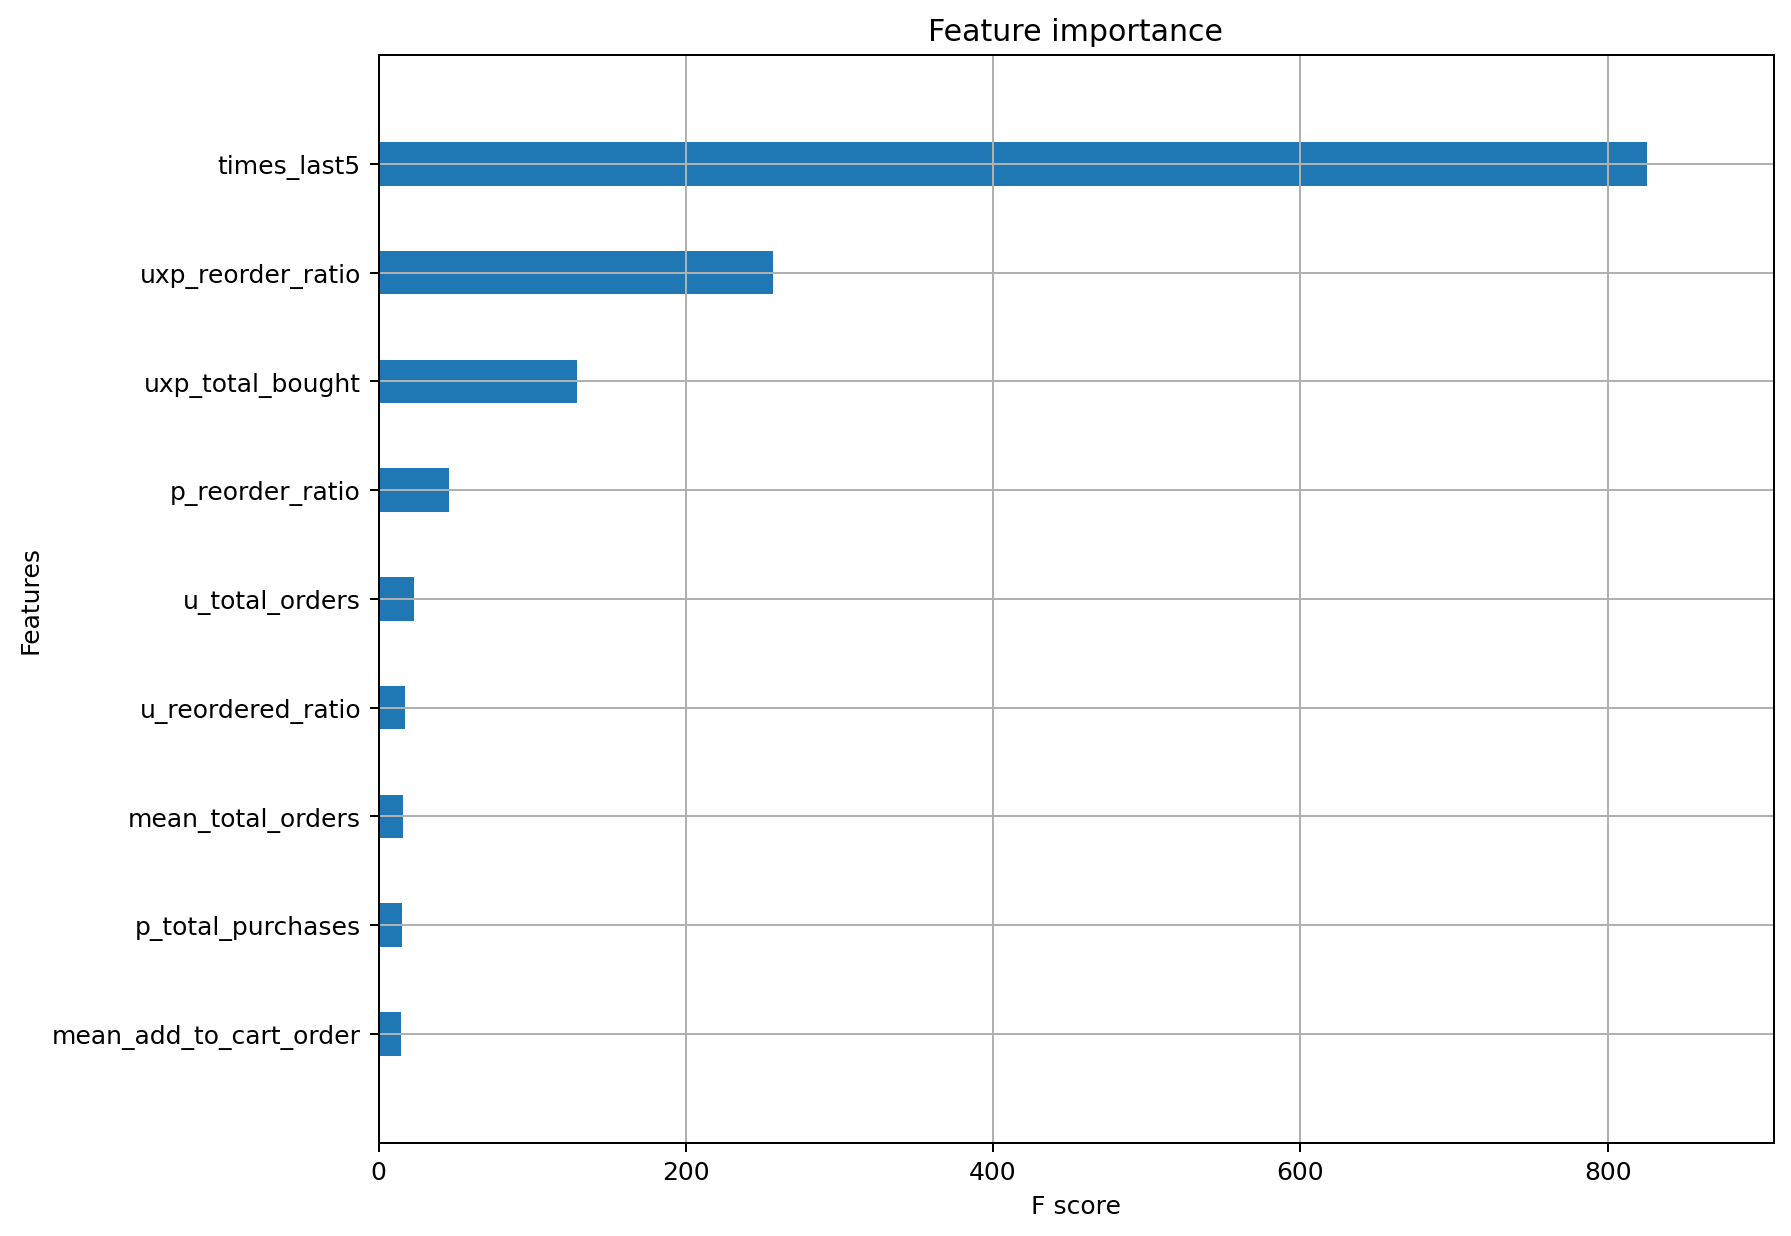

In [63]:
%matplotlib inline
fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)
plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)
pyplot.show()